In [1]:
import QuantLib as ql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
rub_irs_curve_maturity = ["3M","6M","9M","1Y","2Y","3Y",
                          "4Y","5Y","6Y","7Y","8Y","9Y","10Y","12Y","15Y",]

rub_irs_curve_maturity = [ql.Period(rub_irs_curve_maturity[i]) \
                          for i in range(len(rub_irs_curve_maturity))]

rub_irs_curve_dsrate = [8.51987757,8.68611319,8.90460383,9.04938647,9.16620517,9.16277249,
                        9.119128,9.06260294,9.01015779,8.95942704,8.91830151,8.87442665,
                        8.83969915,8.8362406,8.79850223,]

usd_fra_curve_maturity = ["3M","6M","9M","12M","1Y3M","1Y6M",
                          "1Y9M","2Y","2Y3M","2Y6M","2Y9M",
                          "3Y","3Y3M","4Y","5Y","6Y","7Y","8Y",
                          "9Y","10Y","11Y","12Y","15Y","20Y","25Y","30Y"]

usd_fra_curve_maturity = [ql.Period(usd_fra_curve_maturity[i]) \
                          for i in range(len(usd_fra_curve_maturity))]

usd_fra_curve_dsrate = [2.84253062,2.80778295,2.7947691,2.78672186,2.78148933,2.76474858,
                        2.74385753,2.72299332,2.70750966,2.69278142,2.68063008,2.67150303,
                        2.66686195,2.66005416,2.67045368,2.68499512,2.70525985,2.72994097,
                        2.75619769,2.78172399,2.804673,2.82275184,2.857914,2.87560338,
                        2.86786144,2.85316361]

In [3]:
rub = pd.DataFrame(list(zip(rub_irs_curve_maturity, rub_irs_curve_dsrate)),
             columns=["Maturities","Curve"],
             index=['']*len(rub_irs_curve_dsrate))

usd = pd.DataFrame(list(zip(usd_fra_curve_maturity, usd_fra_curve_dsrate)),
             columns=["Maturities","Curve"],
             index=['']*len(usd_fra_curve_dsrate))

In [4]:
rub.head()

,Maturities,Curve
,3M,8.519878
,6M,8.686113
,9M,8.904604
,1Y,9.049386
,2Y,9.166205


In [5]:
usd.head()

,Maturities,Curve
,3M,2.842531
,6M,2.807783
,9M,2.794769
,1Y,2.786722
,1Y3M,2.781489


## Кривые ставок процента для поиска цены валютных деривативов

In [6]:
calc_date = ql.Date(1, 1, 2019)
ql.Settings.instance().evaluationDate = calc_date

In [7]:
calendar = ql.UnitedStates()
business_convention = ql.Unadjusted
day_count = ql.Thirty360()
end_of_month = True
settlement_days = 0
face_amount = 100
coupon_frequency = ql.Period(ql.Semiannual)
settlement_days = 0

In [8]:
def get_spot_rates( yieldcurve, day_count,
                   calendar=ql.UnitedStates(), months=121):
    spots = []
    tenors = []
    ref_date = yieldcurve.referenceDate()
    calc_date = ref_date
    for month in range(0, months):
        yrs = month/12.0
        d = calendar.advance(ref_date, ql.Period(month, ql.Months))
        compounding = ql.Compounded
        freq = ql.Semiannual
        zero_rate = yieldcurve.zeroRate(yrs, compounding, freq)
        tenors.append(yrs)
        eq_rate = zero_rate.equivalentRate(
            day_count,compounding,freq,calc_date,d).rate()
        spots.append(100*eq_rate)
        
    return pd.DataFrame(list(zip(tenors, spots)), columns=["Maturities","Curve"],
                     index=['']*len(tenors))

### Rub

In [9]:
bond_helpers = []
for r, m in zip(rub_irs_curve_dsrate, rub_irs_curve_maturity):
            termination_date = calc_date + m
            schedule = ql.Schedule(calc_date,
                                   termination_date,
                                   coupon_frequency,
                                   calendar,
                                   business_convention,
                                   business_convention,
                                   ql.DateGeneration.Backward,
                                   end_of_month)
            bond_helper = ql.FixedRateBondHelper(
                ql.QuoteHandle(ql.SimpleQuote(face_amount)),
                settlement_days,
                face_amount,
                schedule,
                [r/100.0],
                day_count,
                business_convention)
            bond_helpers.append(bond_helper)

In [10]:
rate_helpers = bond_helpers

In [11]:
yc_linearzero = ql.PiecewiseLinearZero(
    calc_date,rate_helpers,day_count)
yc_cubiczero = ql.PiecewiseCubicZero(calc_date,
                                     rate_helpers,day_count)
splz = get_spot_rates(yc_linearzero, day_count)
spcz = get_spot_rates(yc_cubiczero, day_count)
splz.tail()

,Maturities,Curve
,9.666667,8.781463
,9.750000,8.777620
,9.833333,8.773776
,9.916667,8.769933
,10.000000,8.766090


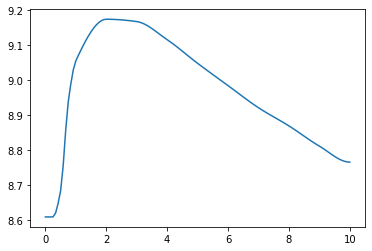

In [12]:
plt.plot(spcz["Maturities"],spcz["Curve"], label="CubicZero")

### Usd

In [13]:
bond_helpers = []
for r, m in zip(usd_fra_curve_dsrate, usd_fra_curve_maturity):
            termination_date = calc_date + m
            schedule = ql.Schedule(calc_date,
                                   termination_date,
                                   coupon_frequency,
                                   calendar,
                                   business_convention,
                                   business_convention,
                                   ql.DateGeneration.Backward,
                                   end_of_month)
            bond_helper = ql.FixedRateBondHelper(
                ql.QuoteHandle(ql.SimpleQuote(face_amount)),
                settlement_days,
                face_amount,
                schedule,
                [r/100.0],
                day_count,
                business_convention)
            bond_helpers.append(bond_helper)

In [14]:
rate_helpers = bond_helpers

In [15]:
yc_linearzero = ql.PiecewiseLinearZero(
    calc_date,rate_helpers,day_count)
yc_cubiczero = ql.PiecewiseCubicZero(calc_date,
                                     rate_helpers,day_count)
splz = get_spot_rates(yc_linearzero, day_count)
spcz = get_spot_rates(yc_cubiczero, day_count)
splz.tail()

,Maturities,Curve
,9.666667,2.782004
,9.750000,2.784370
,9.833333,2.786735
,9.916667,2.789101
,10.000000,2.791467


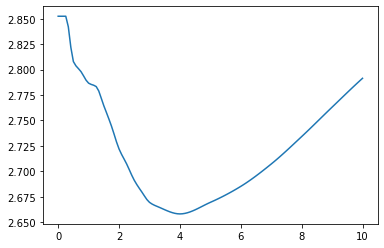

In [16]:
plt.plot(spcz["Maturities"],spcz["Curve"], label="CubicZero")

In [2]:
import scipy.optimize as opt

In [6]:

def make_f(t_step):
    def f(t,a,b,c,d):
        return a + b * (t - t_step) + c * (t - t_step)**2 + d*(t - t_step)**3
    return f
our_f = make_f(2)


opt.newton(our_f, x0=2)


TypeError: f() missing 4 required positional arguments: 'a', 'b', 'c', and 'd'

In [10]:
import numpy as np
np.random.normal(loc=[1,2,3],size=(10,3))

array([[-0.40283087,  2.1768882 ,  3.27977464],
       [ 0.49683298,  1.71040991,  3.44508717],
       [ 4.15925125,  1.0566599 ,  3.22924731],
       [-0.31817554,  2.67458118,  1.8466199 ],
       [ 2.20607664,  3.01918203,  4.29572403],
       [ 1.30910836,  0.96554828,  1.59998377],
       [ 0.52070162,  0.57211832,  2.89580723],
       [-0.77373846,  0.47648246,  2.17940916],
       [ 1.62947619,  1.76761722,  3.24965573],
       [ 0.56386375,  2.64598322,  2.56952336]])

In [11]:
import pandas as pd


In [12]:
pd.read_html('https://www.cbr.ru/hd_base/mosprime/')

[         Дата  1 день  1 нед.  2 нед.  1 мес.  2 мес.  3 мес.  6 мес.
 0  17.01.2020     630     638     640     642     643     645     647
 1  16.01.2020     633     638     640     643     643     647     648
 2  15.01.2020     633     638     639     643     644     647     648
 3  14.01.2020     633     638     639     643     644     647     648
 4  13.01.2020     637     639     640     642     643     645     648
 5  10.01.2020     636     643     641     641     641     643     648]

In [45]:
fx_raw = pd.read_html('./fx_rates.html')[0]
fx_raw.columns = [', '.join(x[1:]) for x in fx_raw.columns]
fx=fx_raw.iloc[:,[0,3]]
fx.columns = ['date','fx_rate']
fx.loc[:,'date']=pd.to_datetime(fx['date'], format="%d/%m/%Y")
fx=fx.sort_values(by='date').reset_index(drop=True)

In [46]:
rub_irs_raw = pd.read_excel('ROISfix history.xlsx')
rub_irs=rub_irs_raw.loc[:,['Дата ставки','3M']]
rub_irs.columns=['date','rub_rate']
rub_irs.loc[:,'date'] = pd.to_datetime(rub_irs['date'], format="%d-%m-%Y")
rub_irs = rub_irs.sort_values(by='date').reset_index(drop=True)

In [48]:
usd_irs_raw = pd.read_excel('./LIBOR USD history.xlsx')
usd_irs=usd_irs_raw.loc[:,['Date','3M']]
usd_irs.columns=['date','usd_rate']
usd_irs.loc[:,'date'] = pd.to_datetime(usd_irs['date'], format="%d.%m.%Y")

usd_irs = usd_irs.sort_values(by='date').reset_index(drop=True)

In [49]:
mrg = pd.merge(
    fx,
    pd.merge(
        rub_irs,
        usd_irs,
        left_on='date',
        right_on='date',
        how='outer'

    ),
    left_on='date',
    right_on='date',
    how='outer'
)

In [78]:
# import seaborn as sns
# import matplotlib.pyplot as plt
import numpy.linalg as linalg
# sns.heatmap(mrg.sort_values('date').isna())
# mrg.index = mrg['date']

decomposed_cov = linalg.cholesky(mrg.interpolate(method='linear').iloc[3:,1:].cov())
decomposed_cor = linalg.cholesky(mrg.interpolate(method='linear').iloc[3:,1:].corr())
decomposed_df_cov = linalg.cholesky(mrg.interpolate(method='linear').iloc[3:,1:].diff().iloc[1:].cov())
decomposed_df_cor = linalg.cholesky(mrg.interpolate(method='linear').iloc[3:,1:].diff().iloc[1:].corr())


In [69]:
decomposed*np.matrix(decomposed).H
mrg.interpolate(method='linear').iloc[3:,1:].cov()


,fx_rate,rub_rate,usd_rate
fx_rate,0.000000e+00,0.000000e+00,-2.775558e-17
rub_rate,0.000000e+00,0.000000e+00,2.775558e-17
usd_rate,-2.775558e-17,2.775558e-17,0.000000e+00


In [79]:
decomposed_cor, decomposed_df_cor

(array([[1.        , 0.        , 0.        ],
        [0.66199483, 0.74950841, 0.        ],
        [0.48107551, 0.69729447, 0.53136314]]),
 array([[ 1.        ,  0.        ,  0.        ],
        [ 0.08370562,  0.99649053,  0.        ],
        [-0.00464425, -0.1941014 ,  0.98097048]]))

In [80]:
pd.DataFrame(decomposed_df_cov).to_pickle('./decomposed_cov.pkl')
pd.DataFrame(decomposed_df_cor).to_pickle('./decomposed_cor.pkl')

In [73]:
fxsigma=0.03


,date,fx_rate
0,2019-01-03,69.0424
1,2019-01-04,68.0103
2,2019-01-08,67.0232
3,2019-01-09,66.9983
4,2019-01-10,67.0305
...,...,...
256,2020-01-10,61.2182
257,2020-01-13,61.1060
258,2020-01-14,61.4044
259,2020-01-15,61.5240
